# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [12]:
!pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\20182672\AppData\Local\anaconda3\envs\MLEngineering\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: accelerate, flair, openml-pytorch, pytorch-lightning, pytorch_revgrad, torchmetrics, torchvision, transformer-smaller-training-vocab


In [13]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import torch
from rdkit import Chem
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn


In [15]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [16]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [17]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


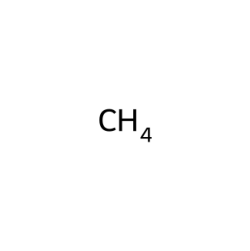

In [18]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.034│     1.335│     0.058
  O  │  8   │    -0.001│    -0.079│     0.010
  C  │  6   │     0.633│    -0.582│    -1.107
  C  │  6   │     0.016│    -0.475│    -2.538
  C  │  6   │     0.749│    -1.790│    -2.803
  C  │  6   │     0.822│    -2.132│    -1.324
  C  │  6   │     2.085│    -1.746│    -2.033
  O  │  8   │     3.126│    -2.601│    -2.329
  C  │  6   │     2.171│    -0.389│    -1.336
  H  │  1   │     0.978│     1.764│     0.077
  H  │  1   │    -0.577│     1.759│    -0.799
  H  │  1   │    -0.553│     1.611│     0.978
  H  │  1   │    -1.068│    -0.621│    -2.507
  H  │  1   │     0.263│     0.403│    -3.145
  H  │  1   │     0.616│    -2.488│    -3.619
  H  │  1   │     0.527│    -3.001│    -0.757
  H  │  1   │     3.513│    -2.329│    -3.169
  H  │  1   │     2.508│     0.486│    -1.904
  H  │  1   │     2.716│    -0.470│    -0.392


SMILE: CO[C@]12C[C@@H]3[C@H]1[C@

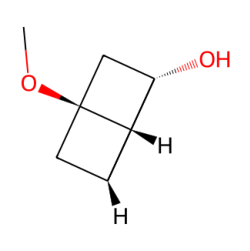

In [19]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

In [25]:
# Check device settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'The available device is {device}')

The available device is cpu


## Task 1

PART II: SMILES
- String sequence to continous values
- Permutational invariance should be taken into account with canonical SMILES

In [ ]:
# Tokenize the SMILES strings
# https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00725-9
# Unclear to me whether we want to encode to values, but seems logical
class SMILESAISTokenizer:
    def __init__(self):
        self.vocab = set()
        self.special_tokens = ['<PAD>', '<START>', '<END>', '<UNK>']
        self.token_to_idx = {}
        self.idx_to_token = {}
    
    def build_vocabulary(self, smiles_list):
        tokens = set()

        for smi in smiles_list:
            tokens.update(self.tokenize(smi))

        tokens = sorted(list(tokens))
        full_vocab = self.special_tokens + tokens
        self.vocab = full_vocab
        self.token_to_idx = {tok: i for i, tok in enumerate(full_vocab)}
        self.idx_to_token = {i: tok for tok, i in self.token_to_idx.items()}

        return full_vocab
    
    def tokenize(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return []

        tokens = []
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if atom.GetIsAromatic():
                symbol = symbol.lower()

            charge = atom.GetFormalCharge()
            chiral = str(atom.GetChiralTag())
            hs = atom.GetTotalNumHs()
            ring = 'R' if atom.IsInRing() else '!R'
            neighbors = sorted([nbr.GetSymbol() for nbr in atom.GetNeighbors()])

            token = f"{symbol}:{charge}:{chiral}:{hs}:{ring}:[{','.join(neighbors)}]"
            tokens.append(token)

        return tokens

    def encode(self, smiles, max_length=None):
        tokens = self.tokenize(smiles)
        encoded = [self.token_to_idx.get(tok, self.token_to_idx['<UNK>']) for tok in tokens]

        if max_length:
            encoded = encoded[:max_length]
            encoded += [self.token_to_idx['<PAD>']] * (max_length - len(encoded))
        return encoded

    def decode(self, indices):
        tokens = [self.idx_to_token.get(idx, '<UNK>') for idx in indices]
        tokens = [tok for tok in tokens if tok not in self.special_tokens]
        return tokens # Not sure whether we need decoder
    

In [ ]:
# # TOY TEST
# smiles_list = [
#     "CCO",         # ethanol
#     "c1ccccc1",    # benzene
#     "C[N+](C)(C)C",# tetramethylammonium
#     "O=C=O"        # carbon dioxide
# ]

# tokenizer = SMILESAISTokenizer()
# # Initialize and build vocab
# vocab = tokenizer.build_vocabulary(smiles_list)
# print("Vocabulary size:", len(vocab))

# # Tokenize and encode a molecule
# encoded = tokenizer.encode("CCO", max_length=10)
# print("Encoded:", encoded)
# print("Decoded tokens:", tokenizer.decode(encoded))

Vocabulary size: 12
Encoded: [6, 5, 10, 0, 0, 0, 0, 0, 0, 0]
Decoded tokens: ['C:0:CHI_UNSPECIFIED:3:!R:[C]', 'C:0:CHI_UNSPECIFIED:2:!R:[C,O]', 'O:0:CHI_UNSPECIFIED:1:!R:[C]']


In [35]:
class SMILESDataset(Dataset):
    def __init__(self, tokenizer, smiles_list, augment=True):
        self.tokenizer = tokenizer
        self.smiles = smiles_list
        self.augment = augment

    def __len__(self):
        return len(self.smiles)

    def randomize_smiles(self, mol):
        return Chem.MolToSmiles(mol, doRandom=True)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return self.__getitem__((idx + 1) % len(self.smiles))  # fallback

        if self.augment:
            smiles = self.randomize_smiles(mol)
        else:
            smiles = Chem.MolToSmiles(mol, canonical=True)

        encoded = self.tokenizer.encode([smiles])[0]
        return torch.tensor(encoded, dtype=torch.long)


In [45]:
# Create tokenzier and dataset
tokenizer = SMILESAISTokenizer()
tokenizer.build_vocabulary(smiles_data)

# Split data into train and validation 80/20, already having a test dataset
train_data = [smiles_data[i] for i in train_idxes[:-int(0.2 * len(train_idxes))]] # select first 80% of train_idxes
val_data = [smiles_data[i] for i in train_idxes[-int(0.2 * len(train_idxes)):]] # select last 20% of train_idxes
test_data = [smiles_data[i] for i in test_idxes]

train_dataset = SMILESDataset(tokenizer, train_data, augment=True)
val_dataset = SMILESDataset(tokenizer, val_data, augment=False)
test_dataset = SMILESDataset(tokenizer, test_data, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Transformer block
# https://pubs.rsc.org/en/content/articlelanding/2022/dd/d2dd00058j
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + self.dropout(attn_output))

        # Feed-forward network with residual connection
        mlp_output = self.mlp(x)
        x = self.layer_norm2(x + self.dropout(mlp_output))

        return x

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [42]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.regression_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, 1)  # Output a single value
        )

    def forward(self, x):
        # Input embedding + positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)

        # Pass through Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)

        # Apply LayerNorm and regression head
        x = self.layer_norm(x)
        x = x.mean(dim=1)  # Global pooling (mean over sequence length)
        x = self.regression_head(x)

        return x

In [44]:
# Inital guess for parameters
vocab_size = len(tokenizer.vocab)  # Vocabulary size from tokenizer
embed_dim = 128  # Embedding dimension
num_heads = 4  # Number of attention heads
ff_dim = 256  # Feed-forward network dimension
num_layers = 6  # Number of Transformer layers
max_len = 100  # Maximum sequence length

model = TransformerDecoder(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len)

# Example input (batch of tokenized SMILES)
input_tokens = torch.randint(0, vocab_size, (32, max_len))  # Batch of 32 sequences
output = model(input_tokens)  # Output shape: (32, 1)
print(output.shape)  # Should be [32, 1]

torch.Size([32, 1])


In [ ]:
# Code to train the model 
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs.squeeze(), fe[train_idxes[:-int(0.2 * len(train_idxes))]].to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs.squeeze(), fe[train_idxes[-int(0.2 * len(train_idxes)):]].to(device))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")

In [ ]:
# Train the model
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3)
# Save the model
torch.save(model.state_dict(), 'transformer_decoder.pth')


## Task 2

## Task 3

In [20]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [21]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [22]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)